In [1]:
import json
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from analysis import combine_results, process_results
from evaluator import Evaluator

warnings.filterwarnings("ignore")

plt.rcParams["text.usetex"] = True
sns.set_style("darkgrid")

## Load Data

In [2]:
RULES_FILEPATH = "data/rules.json"
RESULTS_FILEPATHS = {
    "gpt-4": "./data/results_gpt_4.jsonl",
    "gpt-3.5-turbo": "./data/results_gpt_35_turbo.jsonl",
    "Llama-2-70b-chat-hf": "./data/results_llama_2_70b_chat.jsonl",
}

with open(RULES_FILEPATH) as f:
    data = json.load(f)

results = {}
for run_key, path in RESULTS_FILEPATHS.items():
    with open(path, "r") as f:
        results[run_key] = [json.loads(line) for line in f]

In [3]:
evaluator = Evaluator()
results_list = []

for run_key, run_results in results.items():
    processed_result = process_results(data, run_results, evaluator)
    results_list.append(
        {
            "run_key": run_key,
            "baseline": processed_result["baseline_results"],
            "experiment": processed_result["experiment_results"],
        }
    )

order = list(RESULTS_FILEPATHS.keys())
baseline_results_df, baseline_stats_df = combine_results(
    results_list, "baseline", ["run_key", "rule_id", "rule"], order
)
experiment_results_df, experiment_stats_df = combine_results(
    results_list, "experiment", ["run_key", "num_rules", "trial"], order
)

## Results

In [4]:
color_palette = {
    "gpt-4": "#ab68ff",
    "gpt-3.5-turbo": "#19c37d",
    "Llama-2-70b-chat-hf": "#2962d8",
}

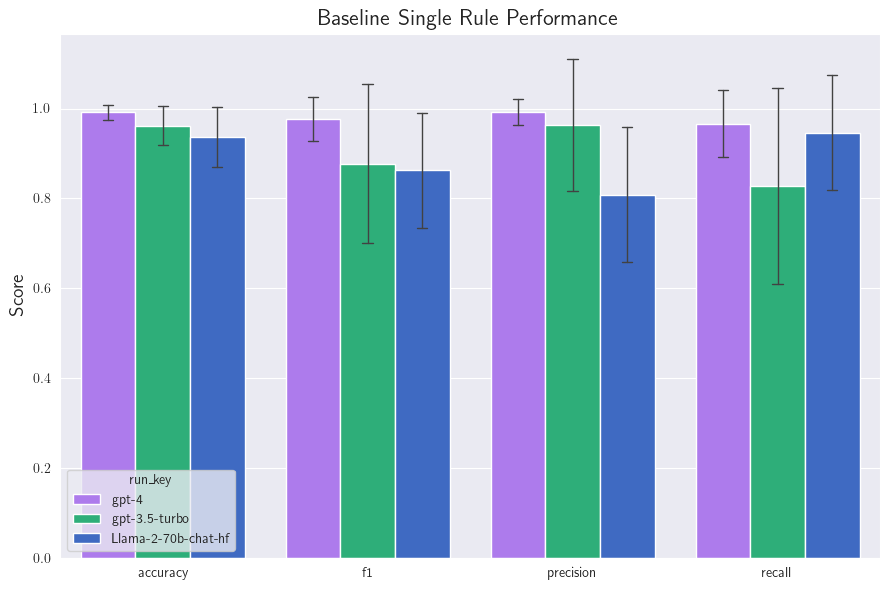

In [5]:
baseline_stats_df_pivot = baseline_stats_df.reset_index().melt(
    id_vars="run_key", value_vars=["accuracy", "f1", "precision", "recall"]
)

plt.figure(figsize=(9, 6))
sns.barplot(
    x="variable",
    y="value",
    hue="run_key",
    data=baseline_stats_df_pivot,
    palette=color_palette,
    ci="sd",
    capsize=0.05,
    errwidth=1,
)
plt.title("Baseline Single Rule Performance", fontsize=16)
plt.xlabel("")
plt.ylabel("Score", fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
baseline_stats_df_pivot.groupby(["run_key", "variable"]).agg(["mean", "std"])

value          
                                   mean       std
run_key             variable                     
gpt-4               accuracy   0.991600  0.017186
                    f1         0.977342  0.048919
                    precision  0.991688  0.029189
                    recall     0.966000  0.074533
gpt-3.5-turbo       accuracy   0.962000  0.042618
                    f1         0.877424  0.176106
                    precision  0.964097  0.146872
                    recall     0.828000  0.217631
Llama-2-70b-chat-hf accuracy   0.936000  0.066639
                    f1         0.862866  0.128221
                    precision  0.808376  0.150869
                    recall     0.946000  0.128110

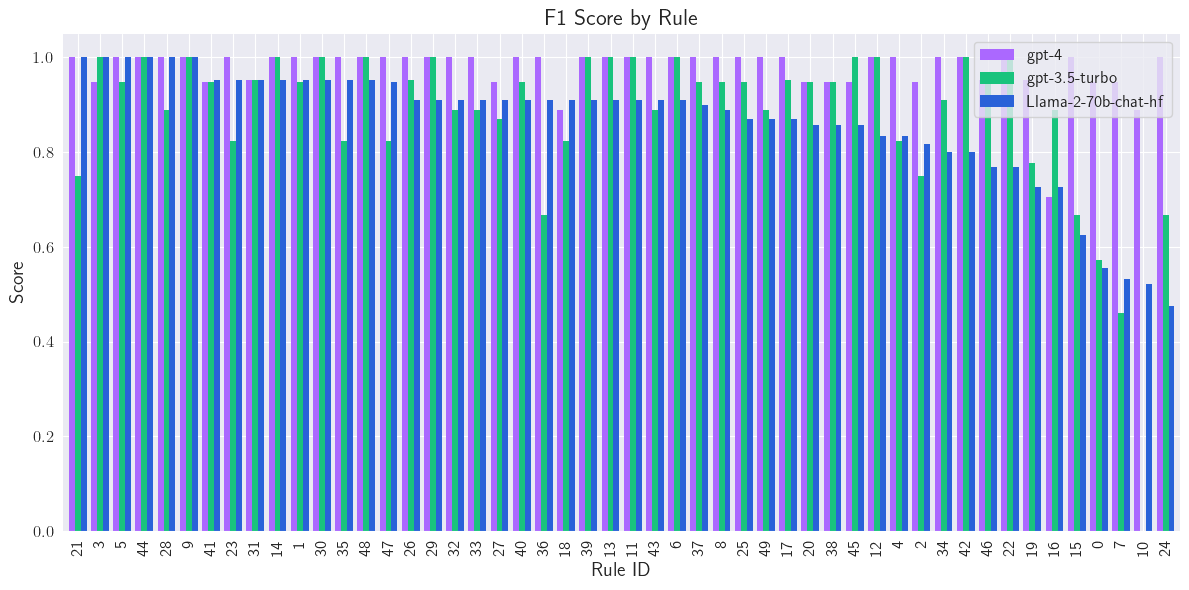

In [7]:
f1_scores_df = baseline_stats_df.pivot_table(
    index="rule_id", columns="run_key", values="f1"
)
f1_scores_df = f1_scores_df.sort_values(f1_scores_df.columns[-1], ascending=False)
ax = f1_scores_df.plot(
    kind="bar",
    figsize=(12, 6),
    width=0.8,
    edgecolor="none",
    color=[color_palette[c] for c in f1_scores_df.columns],
)
ax.set_title("F1 Score by Rule", fontsize=16)
ax.set_xlabel("Rule ID", fontsize=14)
ax.set_ylabel("Score", fontsize=14)
ax.legend(title_fontsize="13", fontsize="12")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True)
plt.tight_layout()
plt.show()

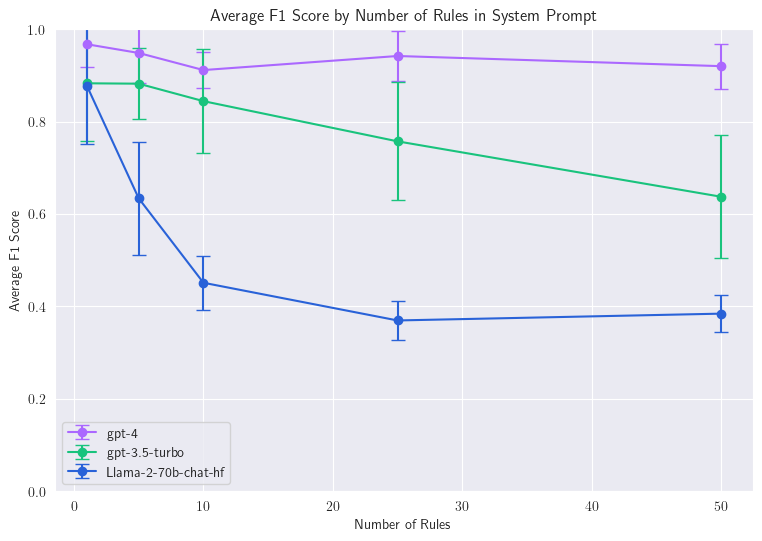

In [8]:
agg_df = experiment_stats_df.groupby(["num_rules", "run_key"]).agg(
    {"f1": ["mean", "std"]}
)
agg_df.columns = ["_".join(col).strip() for col in agg_df.columns.values]
agg_df.reset_index(inplace=True)

plt.figure(figsize=(9, 6))
for run_key in agg_df["run_key"].unique():
    temp_df = agg_df[agg_df["run_key"] == run_key]
    plt.errorbar(
        temp_df["num_rules"],
        temp_df["f1_mean"],
        yerr=temp_df["f1_std"],
        fmt="-o",
        capsize=5,
        label=run_key,
        color=color_palette[run_key],
    )

plt.grid(True)
plt.ylim(0, 1)
plt.title("Average F1 Score by Number of Rules in System Prompt")
plt.xlabel("Number of Rules")
plt.ylabel("Average F1 Score")
plt.legend()
plt.show()

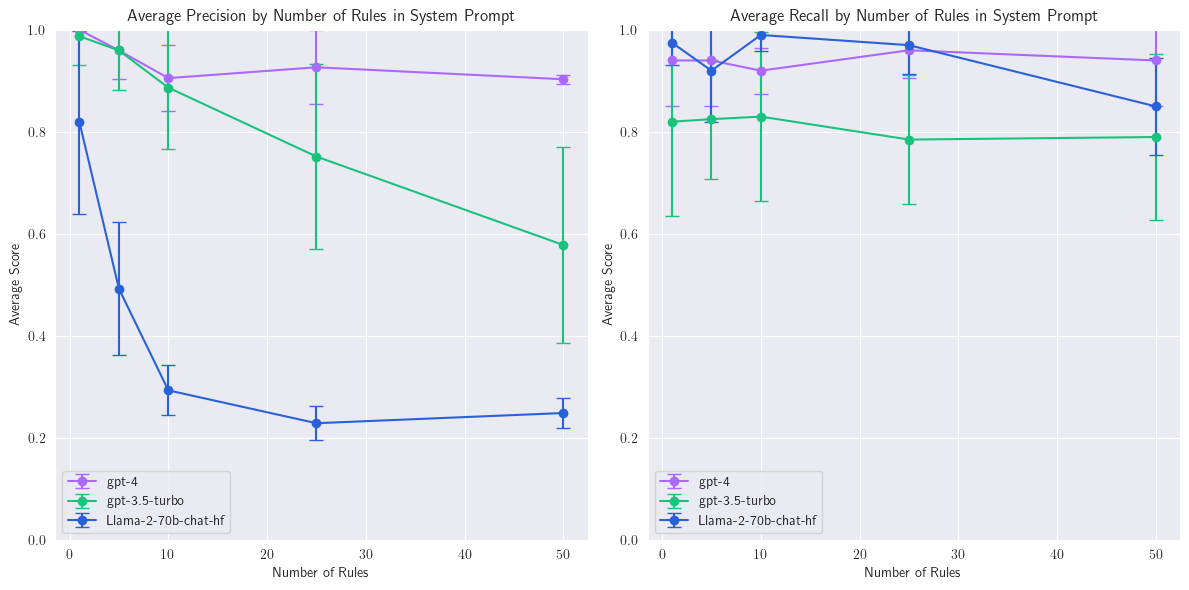

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
metrics = ["precision", "recall"]

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.set_ylim(0, 1)
    ax.set_title(f"Average {metric.capitalize()} by Number of Rules in System Prompt")
    ax.set_xlabel("Number of Rules")
    ax.set_ylabel("Average Score")
    ax.grid(True)

    for run_key in results.keys():
        agg_df = (
            experiment_stats_df.set_index("run_key")
            .loc[run_key]
            .groupby("num_rules")
            .agg({metric: ["mean", "std"]})
        )
        agg_df.columns = ["_".join(col).strip() for col in agg_df.columns.values]
        agg_df.reset_index(inplace=True)

        ax.errorbar(
            agg_df["num_rules"],
            agg_df[f"{metric}_mean"],
            yerr=agg_df[f"{metric}_std"],
            fmt="-o",
            label=run_key,
            capsize=5,
            color=color_palette[run_key],
        )

    ax.legend()

plt.tight_layout()
plt.show()